In [325]:
import pandas as pd
import numpy as np
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.cluster import KMeans,DBSCAN
from scipy import stats
from statistics import mean
import os
from sklearn.metrics.pairwise import euclidean_distances
import math

from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn import svm

# Code

In [326]:
import tcr_emb_prep
import data_processing

In [20]:
def read_barcodes(barcodes_file):
    barcodes = pd.read_csv(barcodes_file, sep = '\t',header = None)
    barcodes.columns = ['barcode']
    barcodes.index += 1
    barcodes['barcode_id'] = barcodes.index
    return barcodes

def read_features(features_file):
    features = pd.read_csv(features_file, sep = '\t',header = None)
    features.index += 1
    features.columns = ['feature_code','value','type']
    features['feature_id'] = features.index
    features['feature_id'] = pd.to_numeric(features['feature_id'])
    return features

def read_matrix(matrix_file):
    matrix = pd.read_csv(matrix_file,sep = '\t')
    matrix = matrix.drop([0])
    matrix[['feature_id','barcode_id', 'count']] = matrix['%%MatrixMarket matrix coordinate integer general'].str.split(expand=True)
    matrix = matrix.drop(['%%MatrixMarket matrix coordinate integer general'], axis = 1)
    matrix = matrix.apply(pd.to_numeric)
    matrix['count']=matrix['count'].astype(int)
    return matrix

def merge_matrix(matrix,barcodes,features):
    matrix = pd.merge(matrix, barcodes, on="barcode_id")
    matrix = pd.merge(matrix, features, on="feature_id")
    #matrix = matrix.drop(['barcode_id','feature_id'],axis=1)
    return matrix


def get_value_matrix(matrix):
    v_t = matrix['value'].str.split('_',n=1,expand=True)
    matrix['value']=v_t[0]
    matrix['value_type']=v_t[1]
    return matrix

## we dont use it here
def get_tetramer_matrix(matrix):
    matrix = matrix.sort_values(by=['count'],ascending=False)
    tetramers = matrix.drop_duplicates('barcode')
    #tetramers = tetramers[tetramers['count']>5]
    tetramers['tetramer'] = tetramers['value']
    tetramers =  tetramers[['barcode_id','tetramer']]
    matrix = pd.merge(matrix, tetramers, on="barcode_id")
    return matrix[['barcode','value','tetramer','count']]

def get_barcode_tetramer(matrix):
    matrix = matrix.sort_values(by=['count'],ascending=False)
    tetramers = matrix.drop_duplicates('barcode')
    tetramers['tetramer'] = tetramers['value']
    tetramers =  tetramers[['barcode','tetramer','count']]
    return tetramers

In [25]:
def prep_annot_data(data):
    data_c = data[data['is_cell']==True].reset_index(drop=True)
    data_c = data_c[data_c['chain'] == "TRB"]
    
    data_c = data_c[-data_c['v_gene'].isna()]
    data_c = data_c[-data_c['j_gene'].isna()]
    
    data_c = data_c[-data_c['cdr3'].isna()]
    #data_no_10x = data_no_10x[-data_no_10x['antigen.epitope'].isna()]
    data_c = data_c[-data_c['v_gene'].str.contains(',')]
    data_c = data_c[-data_c['j_gene'].str.contains(',')]
    data_c = data_c[-data_c['cdr3'].str.contains('\*')]
    data_c = data_c[data_c['cdr3']!='None']
    data_c = data_c[data_c['v_gene']!='None']
    data_c = data_c[data_c['j_gene']!='None']
    return data_c

def merge_anot_matrix(data_c,matrix):
    data_c = pd.merge(data_c,matrix, on='barcode')
    #data_c = data_c[['cdr3','count','tetramer','value','barcode']]
    #data_c = data_c[data_c['cdr3']!='None']
    return data_c

In [28]:
def aminoacid_to_nt(cdr3):
    gene_code = {"A":"GCT", "C":"TGT", "T":"ACT", "S":"TCT", "F": "TTT", "L":"TTA", "I":"ATT", 
                 "M":"ATG", "V":"GTT", "P":"CCT", "Y":"TAT", "H":"CAT","Q": "CAA", "N":"AAT", 
                 "K":"AAA", "D":"GAT", "E":"GAA", "W":"TGG", "R":"CGT", "G":"GGT"}
    res = ''.join([gene_code.get(i) for i in list(cdr3)])
    return res

def filter_table(data,chain):
    if chain== "TRA":
        data = data[data['chain'] == "TRA"]
    
    if chain== "TRB":
        data = data[data['chain'] == "TRB"]
    #cols_input = list(data.columns)
    data = data[-data['v_gene'].isna()]
    data = data[-data['j_gene'].isna()]
    data = data[-(data['v_gene']== "None")]
    data = data[-(data['j_gene']== "None")]
    data = data[-(data['j_gene']== "")]
    data = data[-(data['v_gene']== "")]
    data = data[-data['v_gene'].str.contains(',')]
    data = data[-data['j_gene'].str.contains(',')]

    data = data[-(data['cdr3']== "")]
    data = data[-(data['cdr3']== "None")]
    data = data[-data['cdr3'].isna()]
    data = data[-data['cdr3'].str.contains('\.')]
    data = data[-data['cdr3'].str.contains('\*')]
    
    data = data[data['high_confidence']==True]
    data = data.reset_index(drop=True)
    return data
    
def columns_prep(data):

    data = data.assign(d_gene = ".")
    data = data.assign(count = 1)
    data['DStart'] =  -1
    data['DEnd'] =  -1
    data['VEnd'] =  -1
    data['JStart'] =  -1
    data['freq'] =  -1
    data['cdr3nt'] = data['cdr3'].apply(lambda x: aminoacid_to_nt(x))
    
    data = data.rename(columns={"cdr3": "cdr3aa"})
    data = data.rename(columns={"v_gene": "v"})
    data = data.rename(columns={"j_gene": "j"})
    data = data.assign(subset = ".")
    #data = data.rename(columns={"value": "subset"})
    #data = data.rename(columns={"cdr3_nt": "cdr3nt"})

    cols = ["count", "freq", "cdr3aa", "cdr3nt", "v", "d", "j", "VEnd", "DStart", "DEnd","JStart","contig_id","reads","umis","length","subset"]
    data.drop(set(data.columns) - set(cols), axis=1, inplace=True)
    return data

In [40]:
def pca(data, n):
    
    if type(n) == int:
        x = StandardScaler().fit_transform(data)
        pca = PCA(n_components = n )
        principalComponents = pca.fit_transform(x)
        df_pca = pd.DataFrame(data = principalComponents)
        return df_pca, pca
        
    else:
        return data, pca

In [41]:
def tsne(data,n,random_s,p):
    if type(n) == int:
        X_embedded = TSNE(n_components=n,init='pca',
                         random_state=random_s, perplexity=p).fit_transform(data)
        return X_embedded

In [ ]:
donor = 'donor1'

barcodes_path = 'data/10x_' + donor + '/filtered_feature_bc_matrix/barcodes.tsv'
features_path = 'data/10x_' + donor + '/filtered_feature_bc_matrix/features.tsv'
matrix_path = 'data/10x_' + donor + '/filtered_feature_bc_matrix/matrix.mtx'

# Data proc and prep

## matrix and barcode

In [ ]:
barcodes = data_processing.read_barcodes(barcodes_path)

features = data_processing.read_features(features_path)

matrix = data_processing.read_matrix(matrix_path)

matrix_2 = data_processing.merge_matrix(matrix,barcodes,features)
matrix_2 = data_processing.get_value_matrix(matrix_2)

matrix_3 = matrix_2[matrix_2['type']=='Antibody Capture']
matrix_3 = matrix_3[matrix_3['value_type']!='TotalSeqC']

matrix_t = data_processing.get_tetramer_matrix(matrix_3)
matrix_t


barcodes = read_barcodes('data/filtered_feature_bc_matrix/barcodes.tsv')

features = read_features('data/filtered_feature_bc_matrix/features.tsv')

matrix = read_matrix('data/filtered_feature_bc_matrix/matrix.mtx')

matrix_2 = merge_matrix(matrix,barcodes,features)
matrix_2 = get_value_matrix(matrix_2)

matrix_3 = matrix_2[matrix_2['type']=='Antibody Capture']
matrix_3 = matrix_3[matrix_3['value_type']!='TotalSeqC']

matrix_t = get_tetramer_matrix(matrix_3)
matrix_t


In [ ]:
barcode_tetramer = data_processing.get_barcode_tetramer(matrix_3)
barcode_tetramer

barcode_tetramer = get_barcode_tetramer(matrix_3)
barcode_tetramer

## annot data

In [190]:
data = pd.read_csv("data/vdj_v1_hs_aggregated_donor1_all_contig_annotations.csv", sep = ',')
data_c_annot = data.copy()
data_c_annot = data_c_annot[data_c_annot['is_cell']==True].reset_index(drop=True)
data_c_annot = filter_table(data_c_annot,'TRB')
data_c = data_c_annot.copy()
data_c = merge_anot_matrix(data_c,barcode_tetramer)
data_c

,barcode,is_cell,contig_id,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,full_length,productive,cdr3,cdr3_nt,reads,umis,raw_clonotype_id,raw_consensus_id,tetramer,count
0,AAACCTGAGACAAAGG-4,True,AAACCTGAGACAAAGG-4_contig_1,True,722,TRB,TRBV10-3,TRBD2,TRBJ2-1,TRBC2,True,True,CAISDPGLAGGGGEQFF,TGTGCCATCAGTGACCCCGGACTAGCGGGAGGCGGGGGGGAGCAGT...,32237,18,clonotype19,clonotype19_consensus_1,AVFDRKSDAK,2
1,AAACCTGAGACTGTAA-34,True,AAACCTGAGACTGTAA-34_contig_1,True,688,TRB,TRBV2,None,TRBJ2-1,TRBC2,True,True,CASDTPVGQFF,TGTGCCAGCGATACCCCGGTTGGGCAGTTCTTC,15653,11,clonotype1318,clonotype1318_consensus_1,AVFDRKSDAK,5
2,AAACCTGAGAGCCCAA-5,True,AAACCTGAGAGCCCAA-5_contig_2,True,681,TRB,TRBV5-1,TRBD2,TRBJ2-3,TRBC2,True,True,CASSGGSISTDTQYF,TGCGCCAGCAGTGGCGGGAGTATTAGCACAGATACGCAGTATTTT,15764,7,clonotype1319,clonotype1319_consensus_1,CLLGTYTQDV,1
3,AAACCTGAGAGCTGCA-24,True,AAACCTGAGAGCTGCA-24_contig_1,True,551,TRB,TRBV5-1,TRBD1,TRBJ2-7,TRBC2,True,True,CASSGGQSSYEQYF,TGCGCCAGCAGTGGCGGACAGAGCTCCTACGAGCAGTACTTC,2769,2,clonotype1320,clonotype1320_consensus_1,RAKFKQLL,1
4,AAACCTGAGAGGGATA-8,True,AAACCTGAGAGGGATA-8_contig_1,True,690,TRB,TRBV4-3,TRBD2,TRBJ2-1,TRBC2,True,True,CASSQDPAGGYNEQFF,TGCGCCAGCAGCCAAGACCCAGCGGGGGGGTACAATGAGCAGTTCTTC,36552,18,clonotype1321,clonotype1321_consensus_2,RLRAEAQVK,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45171,TTTGTCATCGAGGTAG-13,True,TTTGTCATCGAGGTAG-13_contig_3,True,679,TRB,TRBV19,None,TRBJ1-5,TRBC1,True,True,CASSTSNEQPQHF,TGTGCCAGTAGTACGTCGAATGAACAGCCCCAGCATTTT,2415,2,clonotype30336,clonotype30336_consensus_2,GILGFVFTL,67
45172,TTTGTCATCTCCAACC-24,True,TTTGTCATCTCCAACC-24_contig_1,True,685,TRB,TRBV7-3,TRBD1,TRBJ2-1,TRBC2,True,True,CASSSDGQSSYNEQFF,TGTGCCAGCAGCTCCGATGGACAGAGCTCCTACAATGAGCAGTTCTTC,10474,7,clonotype30337,clonotype30337_consensus_2,IVTDFSVIK,2
45173,TTTGTCATCTCCTATA-36,True,TTTGTCATCTCCTATA-36_contig_2,True,663,TRB,TRBV4-1,TRBD1,TRBJ2-7,TRBC2,True,True,CASSTGAGVNEQYF,TGCGCCAGCAGTACAGGGGCTGGCGTGAACGAGCAGTACTTC,2490,2,clonotype30338,clonotype30338_consensus_1,AVFDRKSDAK,14
45174,TTTGTCATCTGTCAAG-32,True,TTTGTCATCTGTCAAG-32_contig_1,True,701,TRB,TRBV7-6,TRBD2,TRBJ2-3,TRBC2,True,True,CASSLGASRSTDTQYF,TGTGCCAGCAGCTTAGGGGCTAGCAGAAGCACAGATACGCAGTATTTT,12473,7,clonotype74,clonotype74_consensus_2,KLGGALQAK,28


In [191]:
data_c[data_c.groupby(['barcode','tetramer'])['barcode'].transform('count') > 1]

,barcode,is_cell,contig_id,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,full_length,productive,cdr3,cdr3_nt,reads,umis,raw_clonotype_id,raw_consensus_id,tetramer,count
12,AAACCTGAGCGTAATA-11,True,AAACCTGAGCGTAATA-11_contig_1,True,701,TRB,TRBV7-7,TRBD2,TRBJ2-2,TRBC2,True,True,CASSLEPGLPAGELFF,TGTGCCAGCAGCTTAGAGCCAGGACTACCCGCCGGGGAGCTGTTTTTT,30273,9,clonotype1327,clonotype1327_consensus_1,KLGGALQAK,1
13,AAACCTGAGCGTAATA-11,True,AAACCTGAGCGTAATA-11_contig_3,True,817,TRB,TRBV5-3,TRBD2,TRBJ2-1,TRBC2,True,False,CISVPEATIAGGATMSSSS,TGTATCTCTGTGCCAGAAGCTACTATAGCGGGAGGAGCCACAATGA...,6495,3,clonotype1327,None,KLGGALQAK,1
18,AAACCTGAGGGAGTAA-40,True,AAACCTGAGGGAGTAA-40_contig_2,True,691,TRB,TRBV11-2,TRBD1,TRBJ1-2,TRBC1,True,True,CASSWGGGSHYGYTF,TGTGCCAGCAGCTGGGGGGGCGGTAGCCACTATGGCTACACCTTC,12242,12,clonotype786,clonotype786_consensus_4,IVTDFSVIK,458
19,AAACCTGAGGGAGTAA-40,True,AAACCTGAGGGAGTAA-40_contig_4,True,650,TRB,TRBV28,None,TRBJ2-2,TRBC2,True,True,CASSLYSATGELFF,TGTGCCAGCAGTTTATACTCCGCCACCGGGGAGCTGTTTTTT,7103,7,clonotype786,clonotype786_consensus_5,IVTDFSVIK,458
27,AAACCTGCAAGGGTCA-40,True,AAACCTGCAAGGGTCA-40_contig_1,True,738,TRB,TRBV15,None,TRBJ1-5,TRBC1,True,True,CATSTGDSNQPQHF,TGTGCCACCAGCACGGGTGACAGCAATCAGCCCCAGCATTTT,12221,9,clonotype1332,clonotype1332_consensus_2,AVFDRKSDAK,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45135,TTTGTCACATCGATTG-37,True,TTTGTCACATCGATTG-37_contig_3,True,1264,TRB,TRBV6-5,TRBD1,TRBJ2-4,TRBC2,True,True,CASSYLTGGGRKDIQYF,TGTGCCAGCAGTTACCTCACAGGGGGGGGAAGGAAAGACATTCAGT...,6137,4,clonotype30308,clonotype30308_consensus_2,IVTDFSVIK,150
45146,TTTGTCAGTGCAACTT-12,True,TTTGTCAGTGCAACTT-12_contig_1,True,701,TRB,TRBV13,TRBD1,TRBJ1-2,TRBC1,True,True,CASTRDRPTLGYTF,TGTGCCAGCACCCGGGACAGACCAACGCTGGGCTACACCTTC,29870,13,clonotype30317,clonotype30317_consensus_3,KLGGALQAK,13
45147,TTTGTCAGTGCAACTT-12,True,TTTGTCAGTGCAACTT-12_contig_2,True,843,TRB,TRBV30,TRBD1,TRBJ1-6,TRBC1,True,True,CAWTGTGKIGWDSPLHF,TGTGCCTGGACCGGGACAGGGAAGATCGGATGGGATTCACCCCTCC...,20999,12,clonotype30317,clonotype30317_consensus_1,KLGGALQAK,13
45148,TTTGTCAGTGCATCTA-1,True,TTTGTCAGTGCATCTA-1_contig_1,True,677,TRB,TRBV9,TRBD1,TRBJ2-2,TRBC2,True,True,CASSPWGAGELFF,TGTGCCAGCAGCCCCTGGGGGGCCGGGGAGCTGTTTTTT,29054,7,clonotype30319,clonotype30319_consensus_3,KLGGALQAK,1


In [192]:
data_c_before_dedup = data_c.copy()
data_c = data_c.drop_duplicates(['barcode','tetramer'])
data_c[data_c['barcode']=='AAACCTGAGCGTAATA-11']

,barcode,is_cell,contig_id,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,full_length,productive,cdr3,cdr3_nt,reads,umis,raw_clonotype_id,raw_consensus_id,tetramer,count
12,AAACCTGAGCGTAATA-11,True,AAACCTGAGCGTAATA-11_contig_1,True,701,TRB,TRBV7-7,TRBD2,TRBJ2-2,TRBC2,True,True,CASSLEPGLPAGELFF,TGTGCCAGCAGCTTAGAGCCAGGACTACCCGCCGGGGAGCTGTTTTTT,30273,9,clonotype1327,clonotype1327_consensus_1,KLGGALQAK,1


In [299]:
data_c.to_csv('data_scripts/data_annot_preped.txt', sep='\t', index = False)

# Analysis

## with KLG

In [193]:
data_c_mir = columns_prep(data_c)
data_c_mir

,contig_id,length,v,j,cdr3aa,reads,umis,count,DStart,DEnd,VEnd,JStart,freq,cdr3nt,subset
0,AAACCTGAGACAAAGG-4_contig_1,722,TRBV10-3,TRBJ2-1,CAISDPGLAGGGGEQFF,32237,18,1,-1,-1,-1,-1,-1,TGTGCTATTTCTGATCCTGGTTTAGCTGGTGGTGGTGGTGAACAAT...,.
1,AAACCTGAGACTGTAA-34_contig_1,688,TRBV2,TRBJ2-1,CASDTPVGQFF,15653,11,1,-1,-1,-1,-1,-1,TGTGCTTCTGATACTCCTGTTGGTCAATTTTTT,.
2,AAACCTGAGAGCCCAA-5_contig_2,681,TRBV5-1,TRBJ2-3,CASSGGSISTDTQYF,15764,7,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTGGTGGTTCTATTTCTACTGATACTCAATATTTT,.
3,AAACCTGAGAGCTGCA-24_contig_1,551,TRBV5-1,TRBJ2-7,CASSGGQSSYEQYF,2769,2,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTGGTGGTCAATCTTCTTATGAACAATATTTT,.
4,AAACCTGAGAGGGATA-8_contig_1,690,TRBV4-3,TRBJ2-1,CASSQDPAGGYNEQFF,36552,18,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTCAAGATCCTGCTGGTGGTTATAATGAACAATTTTTT,.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45171,TTTGTCATCGAGGTAG-13_contig_3,679,TRBV19,TRBJ1-5,CASSTSNEQPQHF,2415,2,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTACTTCTAATGAACAACCTCAACATTTT,.
45172,TTTGTCATCTCCAACC-24_contig_1,685,TRBV7-3,TRBJ2-1,CASSSDGQSSYNEQFF,10474,7,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTTCTGATGGTCAATCTTCTTATAATGAACAATTTTTT,.
45173,TTTGTCATCTCCTATA-36_contig_2,663,TRBV4-1,TRBJ2-7,CASSTGAGVNEQYF,2490,2,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTACTGGTGCTGGTGTTAATGAACAATATTTT,.
45174,TTTGTCATCTGTCAAG-32_contig_1,701,TRBV7-6,TRBJ2-3,CASSLGASRSTDTQYF,12473,7,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTTTAGGTGCTTCTCGTTCTACTGATACTCAATATTTT,.


In [194]:
#temp file
file_date = '110623'
file_path = 'data_scripts/10x_trb_' + file_date +'.txt'
data_c_mir.to_csv(file_path, sep='\t', index = False)

In [195]:

mir_path = "mir-1.0-SNAPSHOT.jar"
species = "Human"
chain = "TRB"
prototypes_path = "/home/yuliajk/projects/tcr_emb_2022/data/prototypes_280322.txt"
input_data_path = 'data_scripts/10x_trb_' + file_date +'.txt'
output_path = "data_scripts/10x_trb_" + file_date + "_"

#command = "java -Xmx100G -cp " + mir_path + " com.antigenomics.mir.scripts.Examples cdr3aavj-pairwise-dist " + "-S " + species + " -G " + chain + " -F VDJtools " + "-I " + prototypes_path + " " + input_data_path + " -O " + output_path
#os.system(command)




In [196]:
command = "java -Xmx100G -cp " + mir_path + " com.antigenomics.mir.scripts.Examples cdr3aavj-pairwise-dist " + "-S " + species + " -G " + chain + " -F VDJtools " + "-I " + prototypes_path + " " + input_data_path + " -O " + output_path
os.system(command)

0

In [197]:
prototypes = pd.read_csv(prototypes_path, sep='\t')
data_c_mir = pd.read_csv(input_data_path, sep='\t')
data_c_mir

,contig_id,length,v,j,cdr3aa,reads,umis,count,DStart,DEnd,VEnd,JStart,freq,cdr3nt,subset
0,AAACCTGAGACAAAGG-4_contig_1,722,TRBV10-3,TRBJ2-1,CAISDPGLAGGGGEQFF,32237,18,1,-1,-1,-1,-1,-1,TGTGCTATTTCTGATCCTGGTTTAGCTGGTGGTGGTGGTGAACAAT...,.
1,AAACCTGAGACTGTAA-34_contig_1,688,TRBV2,TRBJ2-1,CASDTPVGQFF,15653,11,1,-1,-1,-1,-1,-1,TGTGCTTCTGATACTCCTGTTGGTCAATTTTTT,.
2,AAACCTGAGAGCCCAA-5_contig_2,681,TRBV5-1,TRBJ2-3,CASSGGSISTDTQYF,15764,7,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTGGTGGTTCTATTTCTACTGATACTCAATATTTT,.
3,AAACCTGAGAGCTGCA-24_contig_1,551,TRBV5-1,TRBJ2-7,CASSGGQSSYEQYF,2769,2,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTGGTGGTCAATCTTCTTATGAACAATATTTT,.
4,AAACCTGAGAGGGATA-8_contig_1,690,TRBV4-3,TRBJ2-1,CASSQDPAGGYNEQFF,36552,18,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTCAAGATCCTGCTGGTGGTTATAATGAACAATTTTTT,.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42727,TTTGTCATCGAGGTAG-13_contig_3,679,TRBV19,TRBJ1-5,CASSTSNEQPQHF,2415,2,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTACTTCTAATGAACAACCTCAACATTTT,.
42728,TTTGTCATCTCCAACC-24_contig_1,685,TRBV7-3,TRBJ2-1,CASSSDGQSSYNEQFF,10474,7,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTTCTGATGGTCAATCTTCTTATAATGAACAATTTTTT,.
42729,TTTGTCATCTCCTATA-36_contig_2,663,TRBV4-1,TRBJ2-7,CASSTGAGVNEQYF,2490,2,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTACTGGTGCTGGTGTTAATGAACAATATTTT,.
42730,TTTGTCATCTGTCAAG-32_contig_1,701,TRBV7-6,TRBJ2-3,CASSLGASRSTDTQYF,12473,7,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTTTAGGTGCTTCTCGTTCTACTGATACTCAATATTTT,.


In [198]:
data_c_b_dists_raw = pd.read_csv(str(output_path + '.dist.txt'), sep = '\t')
data_c_b_dists_raw

,id1,id2,v.score,j.score,cdr3.score
0,1,1,137.0,54.0,22.0
1,1,2,141.0,41.0,9.0
2,1,3,323.0,45.0,7.0
3,1,4,161.0,54.0,9.0
4,1,5,102.0,85.0,37.0
...,...,...,...,...,...
12819595,42732,296,125.0,47.0,5.0
12819596,42732,297,91.0,47.0,9.0
12819597,42732,298,184.0,47.0,11.0
12819598,42732,299,94.0,47.0,13.0


In [199]:
data_c_b_dists_raw['cdr3_idx'] = 'cdr3_' + data_c_b_dists_raw["id2"].astype(str)
data_c_b_dists_raw['v_idx'] = 'v_' + data_c_b_dists_raw["id2"].astype(str)
data_c_b_dists_raw['j_idx'] = 'j_' + data_c_b_dists_raw["id2"].astype(str)
data_c_b_dist = pd.concat([data_c_b_dists_raw.pivot(index='id1',columns='cdr3_idx',values='cdr3.score').reset_index(),
                     data_c_b_dists_raw.pivot(index='id1',columns='v_idx',values='v.score').reset_index(),
                     data_c_b_dists_raw.pivot(index='id1',columns='j_idx',values='j.score').reset_index()], axis=1)
data_c_b_dist = data_c_b_dist.drop('id1',axis=1)
data_c_b_dist = data_c_b_dist.set_index(data_c['barcode'],drop = True)

In [200]:
pca_df, pca_model = pca(data_c_b_dist,50)
pca_df_data = pca_df.copy()
pca_df_data['barcode']=data_c_b_dist.index

In [201]:
pca_df_data=pca_df_data.merge(data_c[['barcode','tetramer']], on='barcode')
pca_df_data= pca_df_data.groupby(['barcode']).first().reset_index()
pca_df_data

,barcode,0,1,2,3,4,5,6,7,8,...,41,42,43,44,45,46,47,48,49,tetramer
0,AAACCTGAGACAAAGG-4,-9.016415,9.762288,-1.793373,-4.285197,7.341001,-4.667218,-6.052950,11.661724,0.951513,...,-0.883625,-0.130226,1.660857,0.472362,-0.657028,0.325367,-1.453110,-0.152085,0.446571,AVFDRKSDAK
1,AAACCTGAGACTGTAA-34,-3.526768,-5.370103,4.512127,0.812362,8.288965,-2.273818,-4.175450,12.538728,11.375713,...,2.484102,-0.239010,0.715475,0.217485,0.937014,-1.752025,-0.737052,1.131246,1.035044,AVFDRKSDAK
2,AAACCTGAGAGCCCAA-5,-16.539407,-11.086502,-6.110582,10.721033,-4.198391,-8.307538,9.431032,-1.404093,2.284866,...,2.159187,0.154137,1.832636,-0.923424,-0.739256,-0.895190,0.056378,-0.872339,1.458674,CLLGTYTQDV
3,AAACCTGAGAGCTGCA-24,-16.652245,-10.869311,-2.666788,-7.276193,-2.109232,5.214259,13.447880,-5.244634,1.400219,...,1.945822,-0.163620,1.441552,0.176304,-0.196104,0.627058,-0.743374,1.555739,1.172086,RAKFKQLL
4,AAACCTGAGAGGGATA-8,-15.327383,-2.610032,-1.731965,-3.107565,9.004070,-2.119355,6.929724,11.553352,-9.708625,...,-2.658127,0.167894,-0.437691,-1.520157,-1.981916,1.432845,-0.606917,-0.561548,0.931066,RLRAEAQVK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42727,TTTGTCATCGAGGTAG-13,3.659382,9.612436,-9.431606,16.880788,-7.704573,17.678493,-2.443592,1.289328,-1.504629,...,-0.066709,0.173001,-0.328946,-1.077990,0.431761,-0.693508,-1.169299,0.505151,0.591519,GILGFVFTL
42728,TTTGTCATCTCCAACC-24,-13.765347,-15.436153,1.972722,-4.322033,12.782030,1.474136,-7.409185,7.714906,-5.256733,...,-1.688765,-0.756337,-0.512950,-1.273466,-1.051335,0.700195,1.974757,-0.684989,0.695621,IVTDFSVIK
42729,TTTGTCATCTCCTATA-36,-17.815154,-3.255747,-0.208215,-3.837888,-1.024955,3.142679,9.372120,0.580658,-8.093685,...,0.529649,0.281230,-1.100134,-0.085337,-2.208891,-1.264143,-0.980873,0.057515,-1.430082,AVFDRKSDAK
42730,TTTGTCATCTGTCAAG-32,-15.580233,-17.862416,-0.672215,9.486052,-2.113255,-6.330695,-8.575541,-1.472631,1.789615,...,-1.844001,0.716540,1.324888,-0.785247,0.553411,-0.241067,-0.124567,-0.233033,0.191426,KLGGALQAK


/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, '2 component')

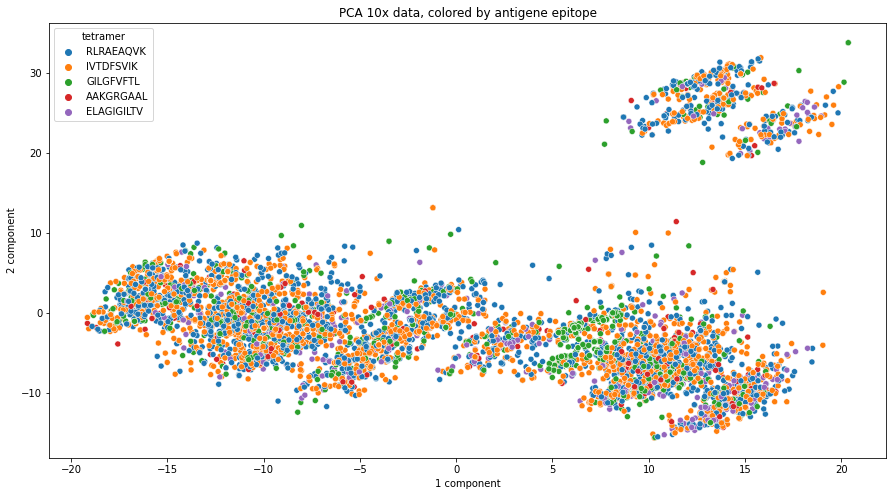

In [202]:
pc1 = 1
pc2 = 2
plt.figure(figsize=(15,8))
ax = sns.scatterplot(pc1, pc2, data=pca_df_data[pca_df_data['tetramer'].isin(['AAKGRGAAL','GILGFVFTL','ELAGIGILTV','RLRAEAQVK','IVTDFSVIK'])], hue='tetramer')
ax.set_title("PCA 10x data, colored by antigene epitope")
ax.set_xlabel(str(pc1)+" component")
ax.set_ylabel(str(pc2)+" component")

In [203]:
X_embedded = tsne(pca_df,2,0,5)
tsne_df = pd.DataFrame(data = X_embedded, columns = ['DM1', 'DM2'])

In [204]:

tsne_df_data = tsne_df.copy()
#tsne_df_data['cdr3']=data_c_b_dist.index
tsne_df_data['barcode']=data_c_b_dist.index

In [205]:
tsne_df_data=tsne_df_data.merge(data_c[['barcode','tetramer']], on='barcode')
tsne_df_data= tsne_df_data.groupby(['barcode']).first().reset_index()
tsne_df_data

,barcode,DM1,DM2,tetramer
0,AAACCTGAGACAAAGG-4,-8.158154,33.844772,AVFDRKSDAK
1,AAACCTGAGACTGTAA-34,2.939528,-16.172779,AVFDRKSDAK
2,AAACCTGAGAGCCCAA-5,-53.365990,-38.848999,CLLGTYTQDV
3,AAACCTGAGAGCTGCA-24,-42.165443,-34.101444,RAKFKQLL
4,AAACCTGAGAGGGATA-8,-26.194118,-8.185353,RLRAEAQVK
...,...,...,...,...
42727,TTTGTCATCGAGGTAG-13,4.059028,17.323557,GILGFVFTL
42728,TTTGTCATCTCCAACC-24,-16.150593,-48.999592,IVTDFSVIK
42729,TTTGTCATCTCCTATA-36,-69.035828,-7.586586,AVFDRKSDAK
42730,TTTGTCATCTGTCAAG-32,-62.687305,-66.356979,KLGGALQAK


/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


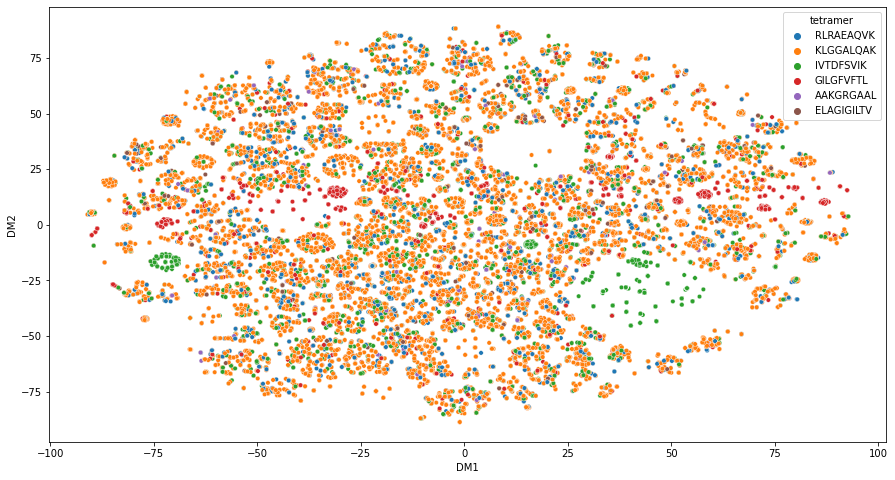

In [206]:
plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=tsne_df_data[tsne_df_data['tetramer'].isin(['KLGGALQAK','AAKGRGAAL','GILGFVFTL','ELAGIGILTV','RLRAEAQVK','IVTDFSVIK'])], hue='tetramer',s=20)
#ax = sns.scatterplot('DM1', 'DM2', data=tsne_df,s=10)
#ax.text(x=0.5, y=1.1, s='TSNE of VDJdb 10x data after PCA, colored by cell.subset', fontsize=12, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
#ax.text(x=0.5, y=1.05, s='TCRemb', fontsize=10, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)
#ax.set_title("TSNE of VDJdb 10x data after PCA, colored by j segment")

/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


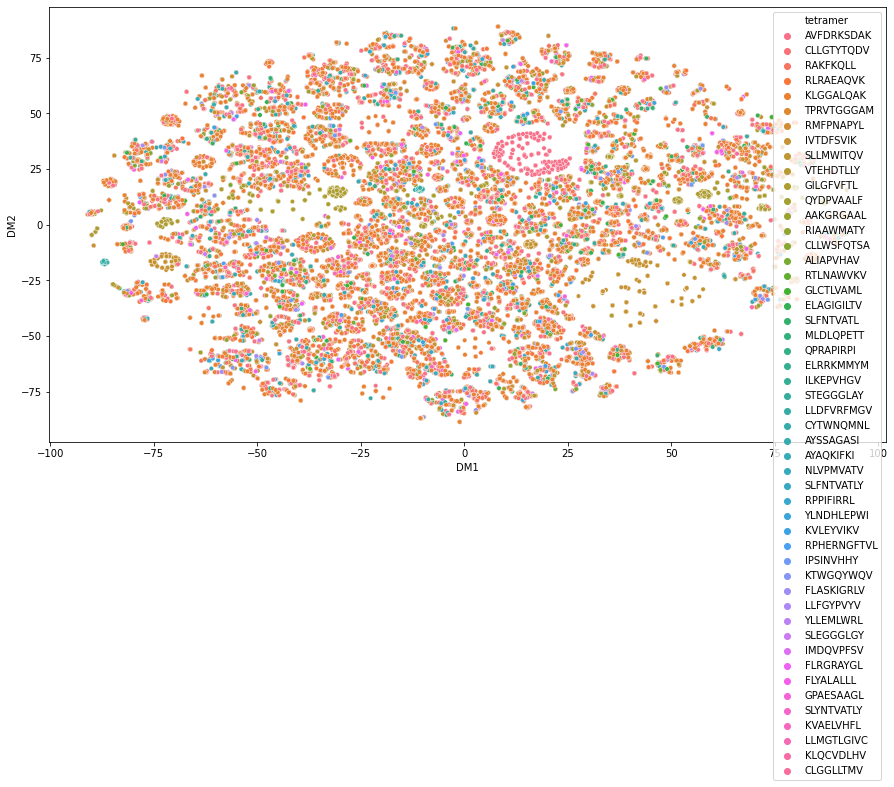

In [207]:
plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=tsne_df_data, hue='tetramer',s=20)
#ax = sns.scatterplot('DM1', 'DM2', data=tsne_df,s=10)
#ax.text(x=0.5, y=1.1, s='TSNE of VDJdb 10x data after PCA, colored by cell.subset', fontsize=12, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
#ax.text(x=0.5, y=1.05, s='TCRemb', fontsize=10, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)
#ax.set_title("TSNE of VDJdb 10x data after PCA, colored by j segment")

## without KLG

In [208]:
data_c = data_c[data_c['tetramer']!='KLGGALQAK'].reset_index(drop=True)

In [209]:
data_c_mir = columns_prep(data_c)
data_c_mir

,contig_id,length,v,j,cdr3aa,reads,umis,count,DStart,DEnd,VEnd,JStart,freq,cdr3nt,subset
0,AAACCTGAGACAAAGG-4_contig_1,722,TRBV10-3,TRBJ2-1,CAISDPGLAGGGGEQFF,32237,18,1,-1,-1,-1,-1,-1,TGTGCTATTTCTGATCCTGGTTTAGCTGGTGGTGGTGGTGAACAAT...,.
1,AAACCTGAGACTGTAA-34_contig_1,688,TRBV2,TRBJ2-1,CASDTPVGQFF,15653,11,1,-1,-1,-1,-1,-1,TGTGCTTCTGATACTCCTGTTGGTCAATTTTTT,.
2,AAACCTGAGAGCCCAA-5_contig_2,681,TRBV5-1,TRBJ2-3,CASSGGSISTDTQYF,15764,7,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTGGTGGTTCTATTTCTACTGATACTCAATATTTT,.
3,AAACCTGAGAGCTGCA-24_contig_1,551,TRBV5-1,TRBJ2-7,CASSGGQSSYEQYF,2769,2,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTGGTGGTCAATCTTCTTATGAACAATATTTT,.
4,AAACCTGAGAGGGATA-8_contig_1,690,TRBV4-3,TRBJ2-1,CASSQDPAGGYNEQFF,36552,18,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTCAAGATCCTGCTGGTGGTTATAATGAACAATTTTTT,.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28751,TTTGTCATCGAGCCCA-39_contig_1,686,TRBV7-9,TRBJ1-2,CASSLGGEKTF,15744,13,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTTTAGGTGGTGAAAAAACTTTT,.
28752,TTTGTCATCGAGGTAG-13_contig_3,679,TRBV19,TRBJ1-5,CASSTSNEQPQHF,2415,2,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTACTTCTAATGAACAACCTCAACATTTT,.
28753,TTTGTCATCTCCAACC-24_contig_1,685,TRBV7-3,TRBJ2-1,CASSSDGQSSYNEQFF,10474,7,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTTCTGATGGTCAATCTTCTTATAATGAACAATTTTTT,.
28754,TTTGTCATCTCCTATA-36_contig_2,663,TRBV4-1,TRBJ2-7,CASSTGAGVNEQYF,2490,2,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTACTGGTGCTGGTGTTAATGAACAATATTTT,.


In [210]:
#temp file
file_date = '120623'
file_path = 'data_scripts/10x_trb_' + file_date +'.txt'
data_c_mir.to_csv(file_path, sep='\t', index = False)

In [211]:

mir_path = "mir-1.0-SNAPSHOT.jar"
species = "Human"
chain = "TRB"
prototypes_path = "/home/yuliajk/projects/tcr_emb_2022/data/prototypes_280322.txt"
input_data_path = 'data_scripts/10x_trb_' + file_date +'.txt'
output_path = "data_scripts/10x_trb_" + file_date + "_"


In [212]:
command = "java -Xmx100G -cp " + mir_path + " com.antigenomics.mir.scripts.Examples cdr3aavj-pairwise-dist " + "-S " + species + " -G " + chain + " -F VDJtools " + "-I " + prototypes_path + " " + input_data_path + " -O " + output_path
os.system(command)

0

In [213]:
prototypes = pd.read_csv(prototypes_path, sep='\t')
data_c_mir = pd.read_csv(input_data_path, sep='\t')
data_c_mir

,contig_id,length,v,j,cdr3aa,reads,umis,count,DStart,DEnd,VEnd,JStart,freq,cdr3nt,subset
0,AAACCTGAGACAAAGG-4_contig_1,722,TRBV10-3,TRBJ2-1,CAISDPGLAGGGGEQFF,32237,18,1,-1,-1,-1,-1,-1,TGTGCTATTTCTGATCCTGGTTTAGCTGGTGGTGGTGGTGAACAAT...,.
1,AAACCTGAGACTGTAA-34_contig_1,688,TRBV2,TRBJ2-1,CASDTPVGQFF,15653,11,1,-1,-1,-1,-1,-1,TGTGCTTCTGATACTCCTGTTGGTCAATTTTTT,.
2,AAACCTGAGAGCCCAA-5_contig_2,681,TRBV5-1,TRBJ2-3,CASSGGSISTDTQYF,15764,7,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTGGTGGTTCTATTTCTACTGATACTCAATATTTT,.
3,AAACCTGAGAGCTGCA-24_contig_1,551,TRBV5-1,TRBJ2-7,CASSGGQSSYEQYF,2769,2,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTGGTGGTCAATCTTCTTATGAACAATATTTT,.
4,AAACCTGAGAGGGATA-8_contig_1,690,TRBV4-3,TRBJ2-1,CASSQDPAGGYNEQFF,36552,18,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTCAAGATCCTGCTGGTGGTTATAATGAACAATTTTTT,.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28751,TTTGTCATCGAGCCCA-39_contig_1,686,TRBV7-9,TRBJ1-2,CASSLGGEKTF,15744,13,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTTTAGGTGGTGAAAAAACTTTT,.
28752,TTTGTCATCGAGGTAG-13_contig_3,679,TRBV19,TRBJ1-5,CASSTSNEQPQHF,2415,2,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTACTTCTAATGAACAACCTCAACATTTT,.
28753,TTTGTCATCTCCAACC-24_contig_1,685,TRBV7-3,TRBJ2-1,CASSSDGQSSYNEQFF,10474,7,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTTCTGATGGTCAATCTTCTTATAATGAACAATTTTTT,.
28754,TTTGTCATCTCCTATA-36_contig_2,663,TRBV4-1,TRBJ2-7,CASSTGAGVNEQYF,2490,2,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTACTGGTGCTGGTGTTAATGAACAATATTTT,.


In [214]:
data_c_b_dists_raw = pd.read_csv(str(output_path + '.dist.txt'), sep = '\t')
data_c_b_dists_raw

,id1,id2,v.score,j.score,cdr3.score
0,1,1,137.0,54.0,22.0
1,1,2,141.0,41.0,9.0
2,1,3,323.0,45.0,7.0
3,1,4,161.0,54.0,9.0
4,1,5,102.0,85.0,37.0
...,...,...,...,...,...
8626795,28756,296,125.0,47.0,5.0
8626796,28756,297,91.0,47.0,9.0
8626797,28756,298,184.0,47.0,11.0
8626798,28756,299,94.0,47.0,13.0


In [215]:
data_c_b_dists_raw['cdr3_idx'] = 'cdr3_' + data_c_b_dists_raw["id2"].astype(str)
data_c_b_dists_raw['v_idx'] = 'v_' + data_c_b_dists_raw["id2"].astype(str)
data_c_b_dists_raw['j_idx'] = 'j_' + data_c_b_dists_raw["id2"].astype(str)
data_c_b_dist = pd.concat([data_c_b_dists_raw.pivot(index='id1',columns='cdr3_idx',values='cdr3.score').reset_index(),
                     data_c_b_dists_raw.pivot(index='id1',columns='v_idx',values='v.score').reset_index(),
                     data_c_b_dists_raw.pivot(index='id1',columns='j_idx',values='j.score').reset_index()], axis=1)
data_c_b_dist = data_c_b_dist.drop('id1',axis=1)
data_c_b_dist = data_c_b_dist.set_index(data_c['barcode'],drop = True)

In [216]:
data_c_b_dist

,cdr3_1,cdr3_10,cdr3_100,cdr3_101,cdr3_102,cdr3_103,cdr3_104,cdr3_105,cdr3_106,cdr3_107,...,j_90,j_91,j_92,j_93,j_94,j_95,j_96,j_97,j_98,j_99
barcode,,,,,,,,,,,,,,,,,,,,,
AAACCTGAGACAAAGG-4,22.0,1.0,24.0,15.0,39.0,15.0,6.0,17.0,12.0,22.0,...,41.0,54.0,41.0,62.0,41.0,44.0,54.0,62.0,62.0,44.0
AAACCTGAGACTGTAA-34,15.0,10.0,22.0,13.0,26.0,8.0,13.0,11.0,20.0,19.0,...,41.0,54.0,41.0,62.0,41.0,44.0,54.0,62.0,62.0,44.0
AAACCTGAGAGCCCAA-5,33.0,21.0,18.0,23.0,17.0,15.0,33.0,37.0,13.0,17.0,...,41.0,65.0,41.0,84.0,41.0,39.0,65.0,84.0,60.0,49.0
AAACCTGAGAGCTGCA-24,24.0,17.0,22.0,24.0,23.0,17.0,26.0,28.0,18.0,22.0,...,43.0,54.0,43.0,60.0,43.0,35.0,54.0,60.0,81.0,42.0
AAACCTGAGAGGGATA-8,23.0,13.0,15.0,27.0,36.0,18.0,23.0,19.0,28.0,27.0,...,41.0,54.0,41.0,62.0,41.0,44.0,54.0,62.0,62.0,44.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCATCGAGCCCA-39,5.0,6.0,11.0,16.0,30.0,8.0,18.0,14.0,26.0,22.0,...,80.0,35.0,80.0,41.0,80.0,38.0,35.0,41.0,43.0,37.0
TTTGTCATCGAGGTAG-13,12.0,45.0,15.0,15.0,25.0,35.0,28.0,42.0,23.0,23.0,...,37.0,44.0,37.0,49.0,37.0,44.0,44.0,49.0,42.0,85.0
TTTGTCATCTCCAACC-24,18.0,18.0,16.0,31.0,33.0,14.0,26.0,26.0,27.0,25.0,...,41.0,54.0,41.0,62.0,41.0,44.0,54.0,62.0,62.0,44.0


In [218]:
pca_df, pca_model = pca(data_c_b_dist,50)
pca_df_data = pca_df.copy()
pca_df_data['barcode']=data_c_b_dist.index
pca_df_data=pca_df_data.merge(data_c[['barcode','tetramer']], on='barcode')
pca_df_data= pca_df_data.groupby(['barcode']).first().reset_index()
pca_df_data

,barcode,0,1,2,3,4,5,6,7,8,...,41,42,43,44,45,46,47,48,49,tetramer
0,AAACCTGAGACAAAGG-4,-10.947295,9.614699,-0.105783,-2.116788,-6.960501,-4.933819,-6.954523,12.234770,2.909414,...,-1.499725,1.607032,0.377931,0.819761,-0.909490,-1.179491,0.027293,0.145388,1.129585,AVFDRKSDAK
1,AAACCTGAGACTGTAA-34,-4.496248,-5.727528,4.601858,2.733654,-8.404062,-1.814852,-5.103690,11.975983,11.751289,...,2.178722,0.957417,-0.392271,0.136490,0.496048,-0.141573,-1.984524,1.558260,0.382746,AVFDRKSDAK
2,AAACCTGAGAGCCCAA-5,-17.752708,-12.222906,-5.969620,10.764931,4.995898,-7.729399,11.110367,-0.147470,5.406805,...,1.605335,2.143671,0.908083,-0.934319,-0.943976,0.046497,-1.154227,-0.679796,0.324509,CLLGTYTQDV
3,AAACCTGAGAGCTGCA-24,-17.695149,-12.167549,-4.090582,-7.015639,-0.636149,5.973189,13.071063,-4.250981,3.204430,...,1.771718,2.017138,0.398698,-0.137089,-0.199149,-0.841539,0.253883,1.986294,0.166413,RAKFKQLL
4,AAACCTGAGAGGGATA-8,-16.787083,-3.101504,-1.873705,-0.629291,-9.717535,-0.767256,5.003308,13.379655,-11.839795,...,-2.833757,-0.453898,0.625724,-0.969419,-1.809745,-0.506259,1.288471,-0.376134,0.168540,RLRAEAQVK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28751,TTTGTCATCGAGCCCA-39,19.833834,-12.774773,0.315469,-0.844513,-4.064680,-0.890074,-4.456819,-3.249982,4.393506,...,-0.284613,0.034452,1.113743,-0.706105,-1.658271,-0.325775,-0.747653,-1.744344,0.349562,AVFDRKSDAK
28752,TTTGTCATCGAGGTAG-13,0.939318,9.913370,-6.671805,16.160012,13.505306,17.985726,-4.072216,0.989014,0.354699,...,-0.448578,-0.227453,0.179211,-1.231726,0.101932,-0.989579,-1.081811,0.601468,-1.365072,GILGFVFTL
28753,TTTGTCATCTCCAACC-24,-14.188096,-15.919941,1.010387,-0.905372,-14.187858,0.837616,-9.739756,7.280418,-4.025971,...,-1.474678,-0.211341,-0.308650,-1.172605,-0.444630,1.748185,1.015822,-0.823062,0.974380,IVTDFSVIK
28754,TTTGTCATCTCCTATA-36,-19.099266,-4.761236,-0.810888,-3.818946,-0.172650,3.759634,8.110022,1.920567,-12.759656,...,0.303789,-1.157278,-0.224915,0.351484,-2.829911,-0.222769,-1.131050,-0.280139,0.506687,AVFDRKSDAK


/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, '2 component')

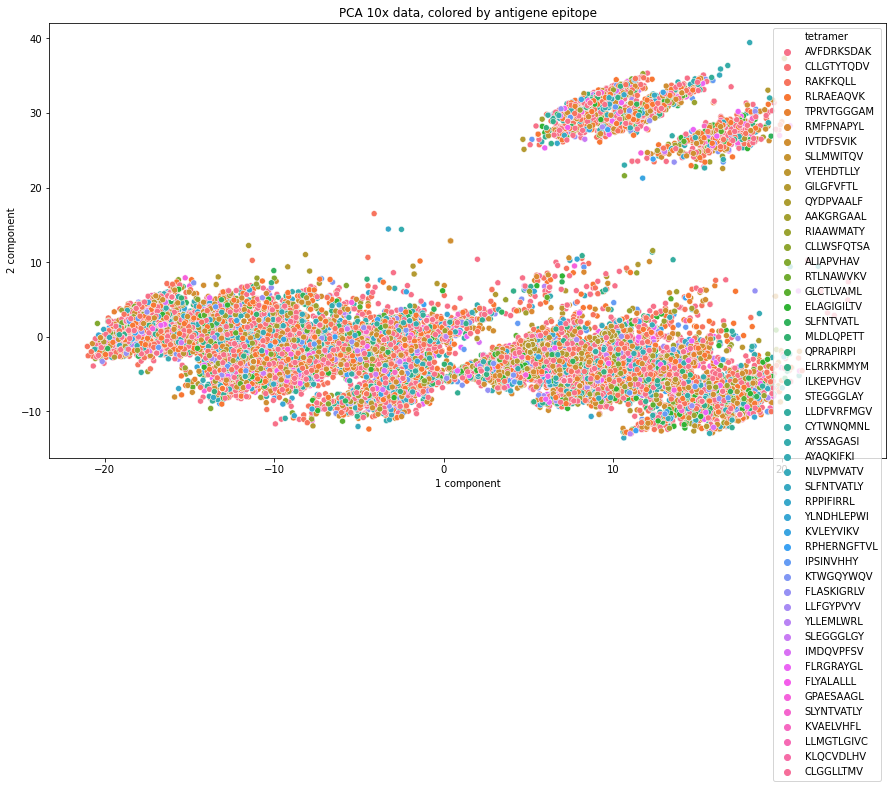

In [219]:
pc1 = 1
pc2 = 2
plt.figure(figsize=(15,8))
ax = sns.scatterplot(pc1, pc2, data=pca_df_data, hue='tetramer')
ax.set_title("PCA 10x data, colored by antigene epitope")
ax.set_xlabel(str(pc1)+" component")
ax.set_ylabel(str(pc2)+" component")

In [302]:
X_embedded = tsne(pca_df,2,0,50)
tsne_df = pd.DataFrame(data = X_embedded, columns = ['DM1', 'DM2'])


tsne_df_data = tsne_df.copy()
#tsne_df_data['cdr3']=data_c_b_dist.index
tsne_df_data['barcode']=data_c_b_dist.index

tsne_df_data=tsne_df_data.merge(data_c[['barcode','tetramer','cdr3']], on='barcode')
tsne_df_data= tsne_df_data.groupby(['barcode']).first().reset_index()
tsne_df_data

,barcode,DM1,DM2,tetramer,cdr3
0,AAACCTGAGACAAAGG-4,-13.472220,56.992031,AVFDRKSDAK,CAISDPGLAGGGGEQFF
1,AAACCTGAGACTGTAA-34,-2.767022,-15.837400,AVFDRKSDAK,CASDTPVGQFF
2,AAACCTGAGAGCCCAA-5,-58.812981,-38.111618,CLLGTYTQDV,CASSGGSISTDTQYF
3,AAACCTGAGAGCTGCA-24,-33.704990,-20.886585,RAKFKQLL,CASSGGQSSYEQYF
4,AAACCTGAGAGGGATA-8,-16.389368,-3.205993,RLRAEAQVK,CASSQDPAGGYNEQFF
...,...,...,...,...,...
28751,TTTGTCATCGAGCCCA-39,67.205338,-22.779652,AVFDRKSDAK,CASSLGGEKTF
28752,TTTGTCATCGAGGTAG-13,0.785598,17.107643,GILGFVFTL,CASSTSNEQPQHF
28753,TTTGTCATCTCCAACC-24,-1.521937,-38.352234,IVTDFSVIK,CASSSDGQSSYNEQFF
28754,TTTGTCATCTCCTATA-36,-37.415844,-11.754817,AVFDRKSDAK,CASSTGAGVNEQYF


/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


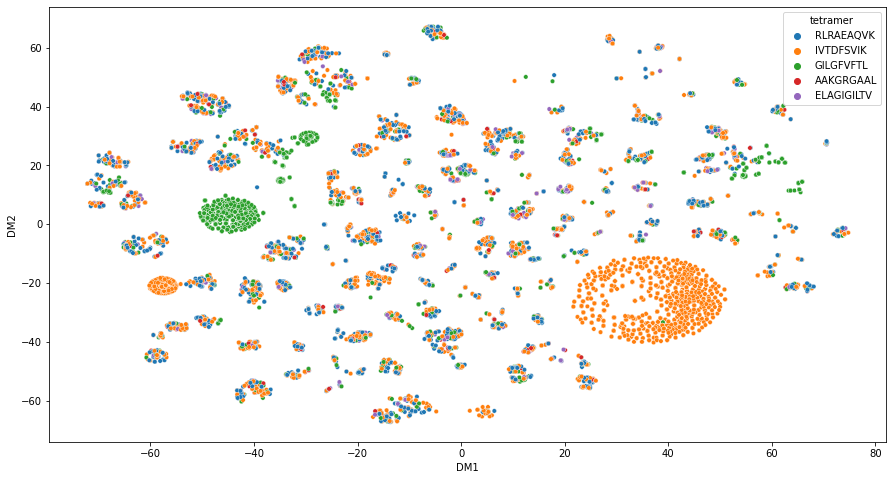

In [303]:
plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=tsne_df_data[tsne_df_data['tetramer'].isin(['KLGGALQAK','AAKGRGAAL','GILGFVFTL','ELAGIGILTV','RLRAEAQVK','IVTDFSVIK'])], hue='tetramer',s=20)
#ax = sns.scatterplot('DM1', 'DM2', data=tsne_df,s=10)
#ax.text(x=0.5, y=1.1, s='TSNE of VDJdb 10x data after PCA, colored by cell.subset', fontsize=12, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
#ax.text(x=0.5, y=1.05, s='TCRemb', fontsize=10, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)
#ax.set_title("TSNE of VDJdb 10x data after PCA, colored by j segment")

/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


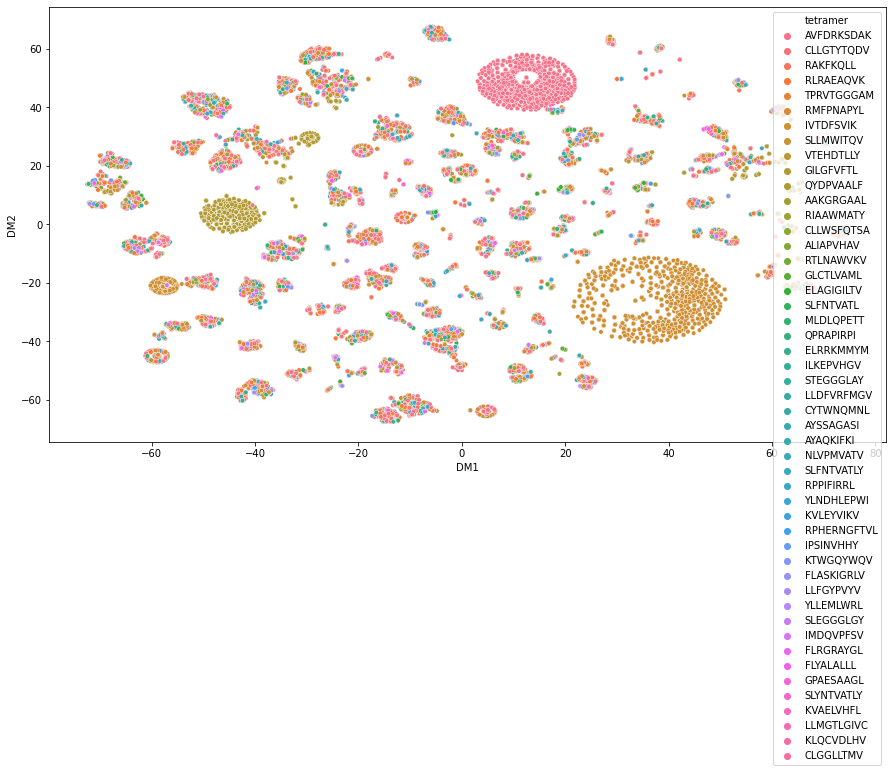

In [304]:
plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=tsne_df_data, hue='tetramer',s=20)
#ax = sns.scatterplot('DM1', 'DM2', data=tsne_df,s=10)
#ax.text(x=0.5, y=1.1, s='TSNE of VDJdb 10x data after PCA, colored by cell.subset', fontsize=12, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
#ax.text(x=0.5, y=1.05, s='TCRemb', fontsize=10, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)
#ax.set_title("TSNE of VDJdb 10x data after PCA, colored by j segment")

### Cluctering

In [305]:
kmeans = KMeans(n_clusters=64, random_state=0).fit(pca_df)

In [307]:
clusters = pd.DataFrame(kmeans.labels_, columns= ['cluster'])
df_kmeans = pd.concat([tsne_df_data, clusters], axis = 1)
df_kmeans

,barcode,DM1,DM2,tetramer,cdr3,cluster
0,AAACCTGAGACAAAGG-4,-13.472220,56.992031,AVFDRKSDAK,CAISDPGLAGGGGEQFF,59
1,AAACCTGAGACTGTAA-34,-2.767022,-15.837400,AVFDRKSDAK,CASDTPVGQFF,24
2,AAACCTGAGAGCCCAA-5,-58.812981,-38.111618,CLLGTYTQDV,CASSGGSISTDTQYF,31
3,AAACCTGAGAGCTGCA-24,-33.704990,-20.886585,RAKFKQLL,CASSGGQSSYEQYF,40
4,AAACCTGAGAGGGATA-8,-16.389368,-3.205993,RLRAEAQVK,CASSQDPAGGYNEQFF,15
...,...,...,...,...,...,...
28751,TTTGTCATCGAGCCCA-39,67.205338,-22.779652,AVFDRKSDAK,CASSLGGEKTF,55
28752,TTTGTCATCGAGGTAG-13,0.785598,17.107643,GILGFVFTL,CASSTSNEQPQHF,21
28753,TTTGTCATCTCCAACC-24,-1.521937,-38.352234,IVTDFSVIK,CASSSDGQSSYNEQFF,23
28754,TTTGTCATCTCCTATA-36,-37.415844,-11.754817,AVFDRKSDAK,CASSTGAGVNEQYF,28


/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


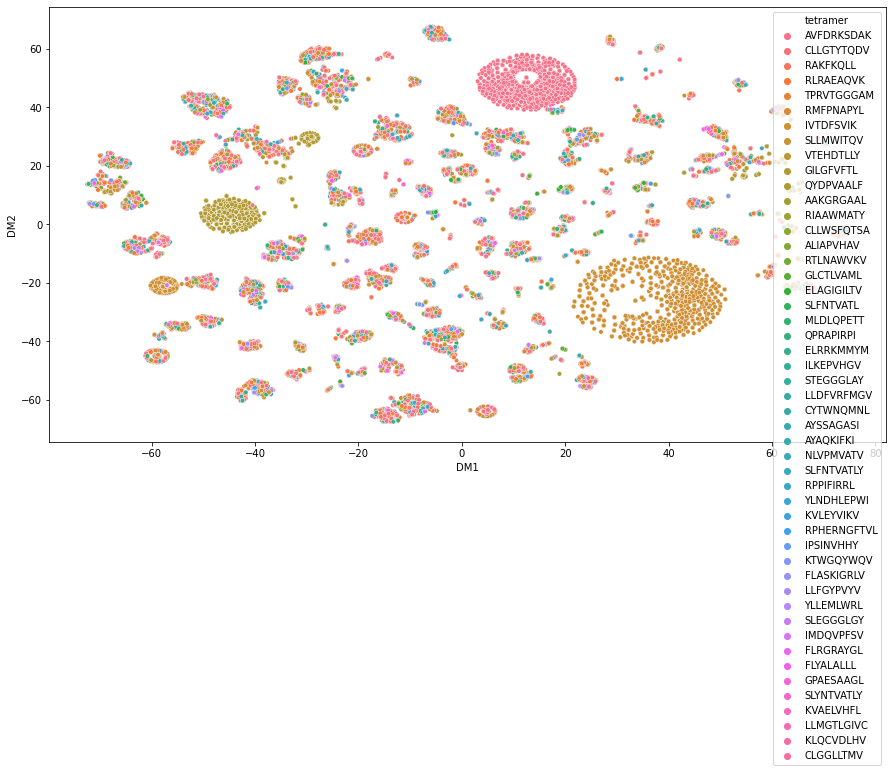

In [308]:
plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=df_kmeans, hue='tetramer',s=20)
#ax = sns.scatterplot('DM1', 'DM2', data=tsne_df,s=10)
#ax.text(x=0.5, y=1.1, s='TSNE of VDJdb 10x data after PCA, colored by cell.subset', fontsize=12, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
#ax.text(x=0.5, y=1.05, s='TCRemb', fontsize=10, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)
#ax.set_title("TSNE of VDJdb 10x data after PCA, colored by j segment")

/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


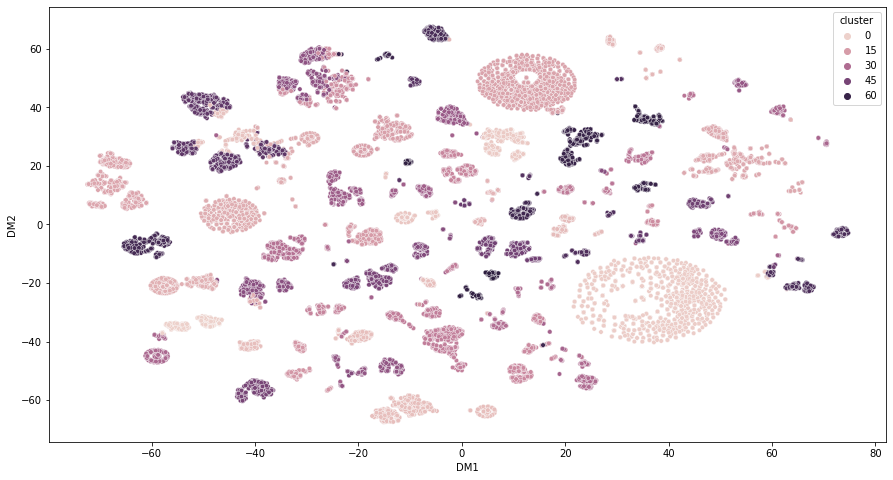

In [309]:
plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=df_kmeans, hue='cluster',s=20)
#ax = sns.scatterplot('DM1', 'DM2', data=tsne_df,s=10)
#ax.text(x=0.5, y=1.1, s='TSNE of VDJdb 10x data after PCA, colored by cell.subset', fontsize=12, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
#ax.text(x=0.5, y=1.05, s='TCRemb', fontsize=10, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)
#ax.set_title("TSNE of VDJdb 10x data after PCA, colored by j segment")

In [315]:
df_kmeans['count_barcodes'] = df_kmeans.groupby('cdr3')['barcode'].transform("size")
df_kmeans[df_kmeans['count_barcodes']>800]

,barcode,DM1,DM2,tetramer,cdr3,cluster,count_barcodes
8,AAACCTGAGATTACCC-16,17.124779,40.796562,AVFDRKSDAK,CASSLYSATGELFF,13,1676
14,AAACCTGAGGGAGTAA-40,50.854630,-22.213812,IVTDFSVIK,CASSWGGGSHYGYTF,1,3701
15,AAACCTGAGGTGCACA-13,16.223171,40.312626,AVFDRKSDAK,CASSLYSATGELFF,13,1676
17,AAACCTGAGTTTAGGA-39,50.826733,-22.218765,IVTDFSVIK,CASSWGGGSHYGYTF,1,3701
26,AAACCTGCACCAGTTA-4,16.527176,45.922611,AVFDRKSDAK,CASSLYSATGELFF,13,1676
...,...,...,...,...,...,...,...
28724,TTTGTCAAGTGAATTG-1,12.478680,50.129745,AVFDRKSDAK,CASSLYSATGELFF,13,1676
28727,TTTGTCACAAGCCATT-20,33.555252,-26.088755,IVTDFSVIK,CASSWGGGSHYGYTF,1,3701
28734,TTTGTCACAGTAAGCG-3,33.555252,-26.088755,IVTDFSVIK,CASSWGGGSHYGYTF,1,3701
28736,TTTGTCACATCGATTG-37,33.555252,-26.088755,IVTDFSVIK,CASSWGGGSHYGYTF,1,3701


In [317]:
df_kmeans[df_kmeans['cluster']==13]

,barcode,DM1,DM2,tetramer,cdr3,cluster,count_barcodes
8,AAACCTGAGATTACCC-16,17.124779,40.796562,AVFDRKSDAK,CASSLYSATGELFF,13,1676
15,AAACCTGAGGTGCACA-13,16.223171,40.312626,AVFDRKSDAK,CASSLYSATGELFF,13,1676
26,AAACCTGCACCAGTTA-4,16.527176,45.922611,AVFDRKSDAK,CASSLYSATGELFF,13,1676
45,AAACCTGTCATGCATG-20,21.090157,43.971684,AVFDRKSDAK,CASSLYSATGELFF,13,1676
60,AAACGGGAGCGCTCCA-25,12.478680,50.129745,AVFDRKSDAK,CASSLYSATGELFF,13,1676
...,...,...,...,...,...,...,...
28622,TTTGCGCCATCACAAC-28,12.478680,50.129745,AVFDRKSDAK,CASSLYSATGELFF,13,1676
28701,TTTGGTTTCGACGGAA-13,12.478680,50.129745,AVFDRKSDAK,CASSLYSATGELFF,13,1676
28703,TTTGGTTTCGTTTAGG-8,12.478680,50.129745,AVFDRKSDAK,CASSLYSATGELFF,13,1676
28716,TTTGTCAAGCCCTAAT-12,12.478680,50.129745,AVFDRKSDAK,CASSLYSATGELFF,13,1676


/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


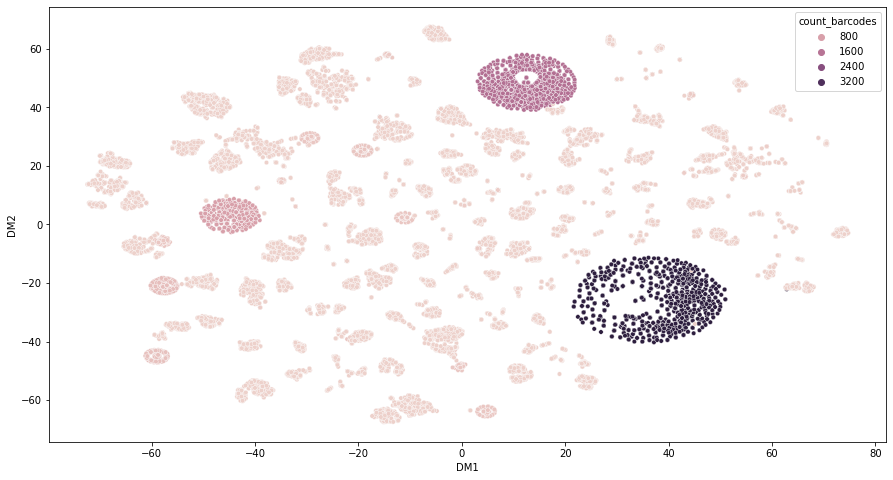

In [314]:
plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=df_kmeans, hue='count_barcodes',s=20)


In [230]:
#binominal test
binom_df = df_kmeans.copy()
binom_df['total_cluster'] = binom_df.groupby('cluster')['cluster'].transform('count')
binom_df['total_epi'] = binom_df.groupby('tetramer')['tetramer'].transform('count')
binom_df['count_mached'] = binom_df.groupby(['tetramer','cluster'])['tetramer'].transform('count')
binom_df['fraction_mached'] = binom_df['count_mached']/binom_df['total_cluster']
binom_df['fraction_mached_e'] = binom_df['total_epi']/len(binom_df.index)
binom_df['p_value'] = binom_df.apply(lambda row: stats.binom_test(row['count_mached'], n=row['total_cluster'], p=row['fraction_mached_e'], alternative='greater'),axis=1)


In [233]:
binom_df = binom_df[binom_df['fraction_mached']>binom_df['fraction_mached_e']]
binom_df_v = binom_df[['tetramer','cluster','total_cluster','total_epi','count_mached','fraction_mached','fraction_mached_e','p_value']].drop_duplicates().sort_values('p_value')
#binom_df_v.to_csv('data_scripts/emb_binom_df.txt',sep='\t', index = False)
binom_df_v

,tetramer,cluster,total_cluster,total_epi,count_mached,fraction_mached,fraction_mached_e,p_value
18,GILGFVFTL,10,1431,3058,1320,0.922432,0.106343,0.000000e+00
14,IVTDFSVIK,1,3745,6708,3722,0.993858,0.233273,0.000000e+00
8,AVFDRKSDAK,13,1713,7058,1677,0.978984,0.245444,0.000000e+00
42,GILGFVFTL,11,1050,3058,529,0.503810,0.106343,1.594374e-226
115,IVTDFSVIK,9,610,6708,339,0.555738,0.233273,1.134197e-65
...,...,...,...,...,...,...,...,...
2856,RPHERNGFTVL,54,238,120,1,0.004202,0.004173,6.303735e-01
2720,SLLMWITQV,28,503,57,1,0.001988,0.001982,6.313964e-01
2958,SLFNTVATLY,58,254,113,1,0.003937,0.003930,6.321531e-01
21388,STEGGGLAY,58,254,113,1,0.003937,0.003930,6.321531e-01


In [244]:
binom_df_cluster = binom_df_v.copy()
binom_df_cluster = binom_df_cluster.sort_values(['fraction_mached'],ascending=False)
binom_df_cluster = binom_df_cluster.drop_duplicates('cluster',keep='first')


,tetramer,cluster,total_cluster,total_epi,count_mached,fraction_mached,fraction_mached_e,p_value
14,IVTDFSVIK,1,3745,6708,3722,0.993858,0.233273,0.000000e+00
8,AVFDRKSDAK,13,1713,7058,1677,0.978984,0.245444,0.000000e+00
18,GILGFVFTL,10,1431,3058,1320,0.922432,0.106343,0.000000e+00
115,IVTDFSVIK,9,610,6708,339,0.555738,0.233273,1.134197e-65
42,GILGFVFTL,11,1050,3058,529,0.503810,0.106343,1.594374e-226
...,...,...,...,...,...,...,...,...
87,RAKFKQLL,6,297,2298,34,0.114478,0.079914,2.244312e-02
73,RAKFKQLL,39,585,2298,65,0.111111,0.079914,4.782427e-03
762,RAKFKQLL,29,219,2298,24,0.109589,0.079914,7.220387e-02
360,RLRAEAQVK,43,291,2313,28,0.096220,0.080435,1.868074e-01


/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


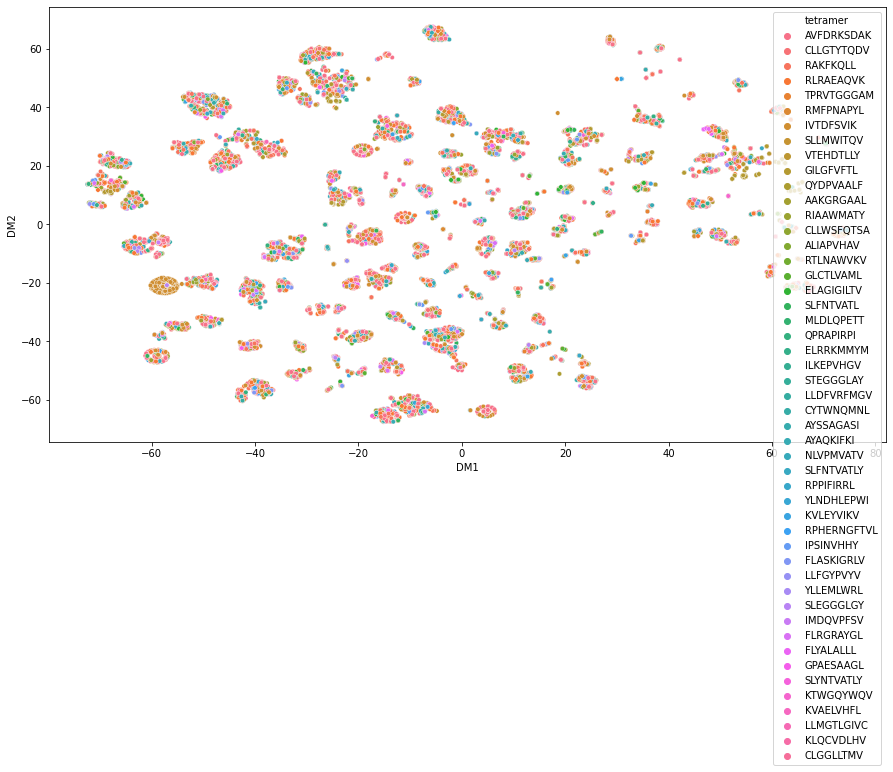

In [249]:
plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=df_kmeans[-df_kmeans['cluster'].isin([1,13,10])], hue='tetramer',s=20)
#ax = sns.scatterplot('DM1', 'DM2', data=tsne_df,s=10)
#ax.text(x=0.5, y=1.1, s='TSNE of VDJdb 10x data after PCA, colored by cell.subset', fontsize=12, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
#ax.text(x=0.5, y=1.05, s='TCRemb', fontsize=10, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)
#ax.set_title("TSNE of VDJdb 10x data after PCA, colored by j segment")

In [234]:
binom_df_g = binom_df_v.copy()
binom_df_g = binom_df_g[binom_df_g['p_value'] < 0.05]
binom_df_g['total_sum_of_clusters'] = binom_df_g.groupby('tetramer')['total_cluster'].transform('sum')
binom_df_g['total_sum_matched'] = binom_df_g.groupby('tetramer')['count_mached'].transform('sum')
binom_df_g[['tetramer','total_epi','total_sum_of_clusters','total_sum_matched']].drop_duplicates()

,tetramer,total_epi,total_sum_of_clusters,total_sum_matched
18,GILGFVFTL,3058,4426,2250
14,IVTDFSVIK,6708,4856,4225
8,AVFDRKSDAK,7058,6595,3271
111,LLDFVRFMGV,346,1490,153
134,ELAGIGILTV,444,4743,209
6126,FLYALALLL,115,1294,27
208,RAKFKQLL,2298,11486,1448
2167,GLCTLVAML,180,3417,59
579,RLRAEAQVK,2313,11158,1373
1666,AYSSAGASI,607,5326,231


In [225]:
distortions = []
K = range(20,100)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(pca_df)
    distortions.append(kmeanModel.inertia_)

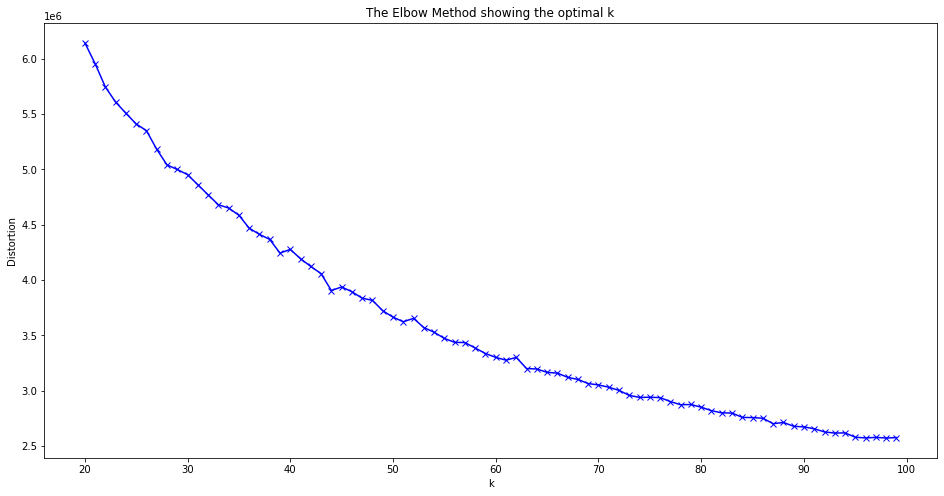

In [226]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

### CDR3 barcodes and tetramer count analysis

In [270]:
data_c['cdr3'].drop_duplicates()

0        CAISDPGLAGGGGEQFF
1              CASDTPVGQFF
2          CASSGGSISTDTQYF
3           CASSGGQSSYEQYF
4         CASSQDPAGGYNEQFF
               ...        
28751          CASSLGGEKTF
28752        CASSTSNEQPQHF
28753     CASSSDGQSSYNEQFF
28754       CASSTGAGVNEQYF
28755      CISAPAVPPAGKAFF
Name: cdr3, Length: 16330, dtype: object

In [273]:
data_c[data_c['count']<5]

,barcode,is_cell,contig_id,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,full_length,productive,cdr3,cdr3_nt,reads,umis,raw_clonotype_id,raw_consensus_id,tetramer,count
0,AAACCTGAGACAAAGG-4,True,AAACCTGAGACAAAGG-4_contig_1,True,722,TRB,TRBV10-3,TRBD2,TRBJ2-1,TRBC2,True,True,CAISDPGLAGGGGEQFF,TGTGCCATCAGTGACCCCGGACTAGCGGGAGGCGGGGGGGAGCAGT...,32237,18,clonotype19,clonotype19_consensus_1,AVFDRKSDAK,2
2,AAACCTGAGAGCCCAA-5,True,AAACCTGAGAGCCCAA-5_contig_2,True,681,TRB,TRBV5-1,TRBD2,TRBJ2-3,TRBC2,True,True,CASSGGSISTDTQYF,TGCGCCAGCAGTGGCGGGAGTATTAGCACAGATACGCAGTATTTT,15764,7,clonotype1319,clonotype1319_consensus_1,CLLGTYTQDV,1
3,AAACCTGAGAGCTGCA-24,True,AAACCTGAGAGCTGCA-24_contig_1,True,551,TRB,TRBV5-1,TRBD1,TRBJ2-7,TRBC2,True,True,CASSGGQSSYEQYF,TGCGCCAGCAGTGGCGGACAGAGCTCCTACGAGCAGTACTTC,2769,2,clonotype1320,clonotype1320_consensus_1,RAKFKQLL,1
4,AAACCTGAGAGGGATA-8,True,AAACCTGAGAGGGATA-8_contig_1,True,690,TRB,TRBV4-3,TRBD2,TRBJ2-1,TRBC2,True,True,CASSQDPAGGYNEQFF,TGCGCCAGCAGCCAAGACCCAGCGGGGGGGTACAATGAGCAGTTCTTC,36552,18,clonotype1321,clonotype1321_consensus_2,RLRAEAQVK,2
6,AAACCTGAGATCGGGT-40,True,AAACCTGAGATCGGGT-40_contig_1,True,739,TRB,TRBV7-9,TRBD1,TRBJ1-2,TRBC1,True,True,CASSRPSTGENYGYTF,TGTGCCAGCAGCCGGCCATCGACAGGGGAGAACTATGGCTACACCTTC,8183,7,clonotype1323,clonotype1323_consensus_1,RMFPNAPYL,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28749,TTTGTCATCCACGTGG-22,True,TTTGTCATCCACGTGG-22_contig_2,True,702,TRB,TRBV27,None,TRBJ1-1,TRBC1,True,True,CASSLSLDLWGAFF,TGTGCCAGCAGTTTATCGCTGGACCTTTGGGGAGCTTTCTTT,11836,4,clonotype30328,clonotype30328_consensus_1,IVTDFSVIK,3
28750,TTTGTCATCCCTTGTG-1,True,TTTGTCATCCCTTGTG-1_contig_1,True,835,TRB,TRBV9,TRBD1,TRBJ1-1,TRBC1,True,True,CASSVGQGGTEAFF,TGTGCCAGCAGCGTAGGTCAGGGGGGCACTGAAGCTTTCTTT,16456,6,clonotype30330,clonotype30330_consensus_1,AVFDRKSDAK,1
28751,TTTGTCATCGAGCCCA-39,True,TTTGTCATCGAGCCCA-39_contig_1,True,686,TRB,TRBV7-9,None,TRBJ1-2,TRBC1,True,True,CASSLGGEKTF,TGTGCCAGCAGCTTAGGCGGCGAGAAGACCTTC,15744,13,clonotype30335,clonotype30335_consensus_2,AVFDRKSDAK,3
28753,TTTGTCATCTCCAACC-24,True,TTTGTCATCTCCAACC-24_contig_1,True,685,TRB,TRBV7-3,TRBD1,TRBJ2-1,TRBC2,True,True,CASSSDGQSSYNEQFF,TGTGCCAGCAGCTCCGATGGACAGAGCTCCTACAATGAGCAGTTCTTC,10474,7,clonotype30337,clonotype30337_consensus_2,IVTDFSVIK,2


In [272]:
data_c[['barcode','cdr3']].drop_duplicates()

,barcode,cdr3
0,AAACCTGAGACAAAGG-4,CAISDPGLAGGGGEQFF
1,AAACCTGAGACTGTAA-34,CASDTPVGQFF
2,AAACCTGAGAGCCCAA-5,CASSGGSISTDTQYF
3,AAACCTGAGAGCTGCA-24,CASSGGQSSYEQYF
4,AAACCTGAGAGGGATA-8,CASSQDPAGGYNEQFF
...,...,...
28751,TTTGTCATCGAGCCCA-39,CASSLGGEKTF
28752,TTTGTCATCGAGGTAG-13,CASSTSNEQPQHF
28753,TTTGTCATCTCCAACC-24,CASSSDGQSSYNEQFF
28754,TTTGTCATCTCCTATA-36,CASSTGAGVNEQYF


In [269]:
data_c[['tetramer','cdr3']].drop_duplicates()

,tetramer,cdr3
0,AVFDRKSDAK,CAISDPGLAGGGGEQFF
1,AVFDRKSDAK,CASDTPVGQFF
2,CLLGTYTQDV,CASSGGSISTDTQYF
3,RAKFKQLL,CASSGGQSSYEQYF
4,RLRAEAQVK,CASSQDPAGGYNEQFF
...,...,...
28751,AVFDRKSDAK,CASSLGGEKTF
28752,GILGFVFTL,CASSTSNEQPQHF
28753,IVTDFSVIK,CASSSDGQSSYNEQFF
28754,AVFDRKSDAK,CASSTGAGVNEQYF


In [256]:
df_good_clusters = df_kmeans[df_kmeans['cluster'].isin([1,13,10])]
df_good_clusters_data = df_good_clusters.merge(data_c, on=['barcode','tetramer'])
df_good_clusters_data

,barcode,DM1,DM2,tetramer,cluster,is_cell,contig_id,high_confidence,length,chain,...,c_gene,full_length,productive,cdr3,cdr3_nt,reads,umis,raw_clonotype_id,raw_consensus_id,count
0,AAACCTGAGATTACCC-16,17.124779,40.796562,AVFDRKSDAK,13,True,AAACCTGAGATTACCC-16_contig_2,True,659,TRB,...,TRBC2,True,True,CASSLYSATGELFF,TGTGCCAGCAGTTTATACTCCGCCACCGGGGAGCTGTTTTTT,38086,10,clonotype2,clonotype2_consensus_3,451
1,AAACCTGAGGGAGTAA-40,50.854630,-22.213812,IVTDFSVIK,1,True,AAACCTGAGGGAGTAA-40_contig_2,True,691,TRB,...,TRBC1,True,True,CASSWGGGSHYGYTF,TGTGCCAGCAGCTGGGGGGGCGGTAGCCACTATGGCTACACCTTC,12242,12,clonotype786,clonotype786_consensus_4,458
2,AAACCTGAGGTGCACA-13,16.223171,40.312626,AVFDRKSDAK,13,True,AAACCTGAGGTGCACA-13_contig_3,True,966,TRB,...,TRBC2,True,True,CASSLYSATGELFF,TGTGCCAGCAGTTTATACTCCGCCACCGGGGAGCTGTTTTTT,8887,4,clonotype2,clonotype2_consensus_3,83
3,AAACCTGAGTTTAGGA-39,50.826733,-22.218765,IVTDFSVIK,1,True,AAACCTGAGTTTAGGA-39_contig_2,True,692,TRB,...,TRBC1,True,True,CASSWGGGSHYGYTF,TGTGCCAGCAGCTGGGGGGGCGGTAGCCACTATGGCTACACCTTC,4074,3,clonotype3,clonotype3_consensus_1,206
4,AAACCTGCAAACCCAT-9,-34.507359,19.962738,GILGFVFTL,10,True,AAACCTGCAAACCCAT-9_contig_1,True,855,TRB,...,TRBC1,True,True,CASSTRSSYEQYF,TGTGCCAGTAGTACCAGGAGCTCCTACGAGCAGTACTTC,8708,16,clonotype442,clonotype442_consensus_2,54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6884,TTTGTCACAAGCCATT-20,33.555252,-26.088755,IVTDFSVIK,1,True,TTTGTCACAAGCCATT-20_contig_1,True,693,TRB,...,TRBC1,True,True,CASSWGGGSHYGYTF,TGTGCCAGCAGCTGGGGGGGCGGTAGCCACTATGGCTACACCTTC,31695,8,clonotype3,clonotype3_consensus_1,268
6885,TTTGTCACAGTAAGCG-3,33.555252,-26.088755,IVTDFSVIK,1,True,TTTGTCACAGTAAGCG-3_contig_1,True,693,TRB,...,TRBC1,True,True,CASSWGGGSHYGYTF,TGTGCCAGCAGCTGGGGGGGCGGTAGCCACTATGGCTACACCTTC,13283,6,clonotype3,clonotype3_consensus_1,337
6886,TTTGTCACATCGATTG-37,33.555252,-26.088755,IVTDFSVIK,1,True,TTTGTCACATCGATTG-37_contig_2,True,693,TRB,...,TRBC1,True,True,CASSWGGGSHYGYTF,TGTGCCAGCAGCTGGGGGGGCGGTAGCCACTATGGCTACACCTTC,13983,8,clonotype30308,clonotype30308_consensus_4,150
6887,TTTGTCAGTAAACCTC-30,-34.951241,14.428849,GILGFVFTL,10,True,TTTGTCAGTAAACCTC-30_contig_2,True,676,TRB,...,TRBC2,True,True,CASSVRSSYEQYF,TGTGCCAGTAGTGTGAGGAGCTCCTACGAGCAGTACTTC,6291,7,clonotype31,clonotype31_consensus_2,136


In [289]:
df_good_clusters_data.to_csv('data_scripts/10x_good_clusters_emb.txt', sep='\t', index = False)

In [287]:
df_good_clusters_data.groupby(['cdr3'])['barcode'].count()

cdr3
CASNPDRSSYEQYF     1
CASRDTGGYTGELFF    1
CASRGASSYEQYF      1
CASRGLNHNTGELFF    1
CASRGQGYTGELFF     1
                  ..
CASSWGTSYEQYF      1
CASSWRAPYEQYF      1
CASSWVGQLTGELFF    1
CASTLAEDTGELFF     1
CASTRGYTGELFF      1
Name: barcode, Length: 130, dtype: int64

In [288]:
df_good_clusters_data.groupby(['cdr3','barcode'])['barcode'].count()

cdr3             barcode            
CASNPDRSSYEQYF   AAAGTAGAGACTAAGT-12    1
CASRDTGGYTGELFF  CGACTTCCATGATCCA-27    1
CASRGASSYEQYF    CCAATCCTCTCCTATA-3     1
CASRGLNHNTGELFF  TTTATGCCAGACAAAT-33    1
CASRGQGYTGELFF   GAACCTAGTTTCGCTC-31    1
                                       ..
CASSWGTSYEQYF    CATCAGAGTTCCGTCT-29    1
CASSWRAPYEQYF    TGACTAGAGTTGTCGT-36    1
CASSWVGQLTGELFF  CGATTGAGTCTTCGTC-9     1
CASTLAEDTGELFF   GTAACGTGTGCGATAG-11    1
CASTRGYTGELFF    CGCTGGATCTTGCAAG-10    1
Name: barcode, Length: 6889, dtype: int64

In [262]:
df_good_clusters_data.groupby(['cdr3','tetramer'])['barcode'].count()

cdr3             tetramer  
CASNPDRSSYEQYF   RLRAEAQVK     1
CASRDTGGYTGELFF  RLRAEAQVK     1
CASRGASSYEQYF    RPPIFIRRL     1
CASRGLNHNTGELFF  LLDFVRFMGV    1
CASRGQGYTGELFF   RLRAEAQVK     1
                              ..
CASSWGTSYEQYF    ELAGIGILTV    1
CASSWRAPYEQYF    AVFDRKSDAK    1
CASSWVGQLTGELFF  AYSSAGASI     1
CASTLAEDTGELFF   GILGFVFTL     1
CASTRGYTGELFF    LLDFVRFMGV    1
Name: barcode, Length: 167, dtype: int64

In [263]:
df_good_clusters_data.groupby(['cdr3','tetramer','barcode'])['barcode'].count()

cdr3             tetramer    barcode            
CASNPDRSSYEQYF   RLRAEAQVK   AAAGTAGAGACTAAGT-12    1
CASRDTGGYTGELFF  RLRAEAQVK   CGACTTCCATGATCCA-27    1
CASRGASSYEQYF    RPPIFIRRL   CCAATCCTCTCCTATA-3     1
CASRGLNHNTGELFF  LLDFVRFMGV  TTTATGCCAGACAAAT-33    1
CASRGQGYTGELFF   RLRAEAQVK   GAACCTAGTTTCGCTC-31    1
                                                   ..
CASSWGTSYEQYF    ELAGIGILTV  CATCAGAGTTCCGTCT-29    1
CASSWRAPYEQYF    AVFDRKSDAK  TGACTAGAGTTGTCGT-36    1
CASSWVGQLTGELFF  AYSSAGASI   CGATTGAGTCTTCGTC-9     1
CASTLAEDTGELFF   GILGFVFTL   GTAACGTGTGCGATAG-11    1
CASTRGYTGELFF    LLDFVRFMGV  CGCTGGATCTTGCAAG-10    1
Name: barcode, Length: 6889, dtype: int64

In [250]:
df_bad_clusters = df_kmeans[-df_kmeans['cluster'].isin([1,13,10])]
df_bad_clusters_data = df_bad_clusters.merge(data_c, on=['barcode','tetramer'])
df_bad_clusters_dataa

,barcode,DM1,DM2,tetramer,cluster
0,AAACCTGAGACAAAGG-4,-13.472220,56.992031,AVFDRKSDAK,59
1,AAACCTGAGACTGTAA-34,-2.767022,-15.837400,AVFDRKSDAK,24
2,AAACCTGAGAGCCCAA-5,-58.812981,-38.111618,CLLGTYTQDV,31
3,AAACCTGAGAGCTGCA-24,-33.704990,-20.886585,RAKFKQLL,40
4,AAACCTGAGAGGGATA-8,-16.389368,-3.205993,RLRAEAQVK,15
...,...,...,...,...,...
28751,TTTGTCATCGAGCCCA-39,67.205338,-22.779652,AVFDRKSDAK,55
28752,TTTGTCATCGAGGTAG-13,0.785598,17.107643,GILGFVFTL,21
28753,TTTGTCATCTCCAACC-24,-1.521937,-38.352234,IVTDFSVIK,23
28754,TTTGTCATCTCCTATA-36,-37.415844,-11.754817,AVFDRKSDAK,28


In [264]:
df_bad_clusters_data.groupby('cdr3')['barcode'].count()

cdr3
CAAAPGSYEQYF            1
CAADSRGGVTEAFF          1
CAAEDGPSGNTIYF          1
CAAFSPGPGHHYGYTF        1
CAAGEETQYF              1
                       ..
CTSVPAVTLPQGEGGELFF     1
CTSVPAVTRDRGCMATPSVR    1
CTSVPAVTTGNTGELFF       1
CTSVPVGTSQIMATPSVR      1
CVRLANTGELFF            1
Name: barcode, Length: 16203, dtype: int64

In [265]:
df_bad_clusters_data.groupby(['cdr3','tetramer','barcode'])['barcode'].count()

cdr3                  tetramer    barcode            
CAAAPGSYEQYF          IVTDFSVIK   AGCCTAACACAAGTAA-28    1
CAADSRGGVTEAFF        GPAESAAGL   AAGACCTGTGCCTGTG-40    1
CAAEDGPSGNTIYF        AVFDRKSDAK  CATGGCGTCACTTCAT-29    1
CAAFSPGPGHHYGYTF      RAKFKQLL    TCAGATGAGCGCCTTG-16    1
CAAGEETQYF            AYSSAGASI   TTTGTCACAAGGACAC-4     1
                                                        ..
CTSVPAVTLPQGEGGELFF   GLCTLVAML   ATGCGATCAGTGAGTG-39    1
CTSVPAVTRDRGCMATPSVR  AVFDRKSDAK  TGTCCCATCGCCAGCA-17    1
CTSVPAVTTGNTGELFF     QYDPVAALF   AGTGAGGGTAAGCACG-39    1
CTSVPVGTSQIMATPSVR    AVFDRKSDAK  ATCGAGTTCTGTCCGT-18    1
CVRLANTGELFF          RLRAEAQVK   TTGGAACGTCGAGTTT-7     1
Name: barcode, Length: 21867, dtype: int64

In [290]:
df_bad_clusters_data.to_csv('data_scripts/10x_bad_clusters_emb.txt', sep='\t', index = False)

## Classification

In [327]:
tetramers = list(tsne_df_data['tetramer'].drop_duplicates())
y_train, y_test,X_train, X_test,  = train_test_split(tsne_df_data['tetramer'],tsne_df,test_size=0.5)
y_test_curv = label_binarize(y_test, classes=tetramers)

### KNN

In [328]:
# Perform KNN
n_neighbors = 10
knn = neighbors.KNeighborsClassifier(n_neighbors)
knn.fit(X_train, y_train)

pred = knn.predict(X_test)
y_pred_curv = label_binarize(pred, classes=tetramers)

In [329]:
n_classes = y_test_curv.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_curv[:,i],y_pred_curv[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
pd.DataFrame(roc_auc.values(),tetramers, columns = ['roc_auc']).sort_values('roc_auc',ascending=False).head(10)

,roc_auc
GILGFVFTL,0.882456
IVTDFSVIK,0.785954
LLDFVRFMGV,0.705693
AVFDRKSDAK,0.653090
FLYALALLL,0.587684
GLCTLVAML,0.550367
ELAGIGILTV,0.535989
RAKFKQLL,0.532563
AYSSAGASI,0.517638
RLRAEAQVK,0.507108
